# Warehouse Storage Optimization

## 1. Storage Location Assignment

### Distance Matrix and Weights

The distance between the IO/points and storage locations were first computed and put in a matrix. A Manhattan distance metric is applied. The distances were then combined with item-specific handling costs and trip frequencies to calculate location-item weigths. The weight matrix reflects the relative importance of each storage position for each SKU and provides the basis for optimizing the assignment of items to locations. In the code cell below, the calculation of the distance and weight matrix is done.


In [1]:
import pandas as pd

# Required storage spaces needed data S_i
storage_spaces = {"A" : 3, "B" : 5, "C" : 2, "D" : 6}
total_spaces = sum(storage_spaces.values())

# Frequency of trips data f_ik
frequency = {"IO Point 1" : {"A" : 150, "B" : 60, "C" : 96, "D" : 175},
            "IO Point 2" : {"A" : 25, "B" : 200, "C" : 15, "D" : 135},
            "IO Point 3" : {"A" : 88, "B" : 150, "C" : 85, "D" : 90},
}
frequency_df = pd.DataFrame(frequency).loc[["A", "B", "C", "D"]]

# Cost data c_ik
cost = {"IO Point 1" : {"A" : 6, "B" : 7, "C" : 4, "D" : 15},
        "IO Point 2" : {"A" : 5, "B" : 3, "C" : 7, "D" : 8},
        "IO Point 3" : {"A" : 5, "B" : 6, "C" : 9, "D" : 12},
}
cost_df = pd.DataFrame(cost).loc[["A", "B", "C", "D"]]

# Define the IO points coordinates
io_points = {1: (2.5, 0.5), 2: (0.5, 2.5), 3: (2.5, 4.5)}

storage_locations = {}
idx = 1
for y in range(4, 0, -1):
    for x in range(1,5):
        storage_locations[idx] = (x, y)
        idx += 1

#print(storage_locations)

def manhattan_distance(point1, point2):
    return abs(point1[0] - point2[0]) + abs(point1[1] - point2[1])

# Calculate distance matrix d_kj
distance_matrix = pd.DataFrame(index=io_points.keys(), columns=storage_locations.keys())

for k, io_coord in io_points.items():
    for j, storage_coord in storage_locations.items():
        distance_matrix.loc[k, j] = manhattan_distance(io_coord, storage_coord)

print("Distance Matrix (d_kj): \n")
print(distance_matrix)

# Calculate weight matrix w_ij
items = ["A", "B", "C", "D"]
weights_matrix = pd.DataFrame(index=items, columns=storage_locations.keys())

for i in items:
    # denominator S_i = required storage spaces for item i (not cost*freq sum)
    S_i = storage_spaces[i]

    for j in storage_locations.keys():
        numerator = 0
        for k in io_points.keys():
            f_ik = frequency_df.loc[i, f"IO Point {k}"]
            c_ik = cost_df.loc[i, f"IO Point {k}"]
            d_kj = distance_matrix.loc[k, j]
            numerator += c_ik * f_ik * d_kj

        weights_matrix.loc[i, j] = numerator / S_i if S_i != 0 else 0

print("Weight matrix w_ij (items x storage locations):")
print(weights_matrix.round(4))



Distance Matrix (d_kj): 

    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15  \
1  5.0  4.0  4.0  5.0  4.0  3.0  3.0  4.0  3.0  2.0  2.0  3.0  2.0  1.0  1.0   
2  2.0  3.0  4.0  5.0  1.0  2.0  3.0  4.0  1.0  2.0  3.0  4.0  2.0  3.0  4.0   
3  2.0  1.0  1.0  2.0  3.0  2.0  2.0  3.0  4.0  3.0  3.0  4.0  5.0  4.0  4.0   

    16  
1  2.0  
2  5.0  
3  5.0  
Weight matrix w_ij (items x storage locations):
            1            2            3            4            5   \
A  1876.666667  1471.666667  1513.333333  2001.666667  1681.666667   
B       1020.0        876.0        996.0       1380.0        996.0   
C       1830.0       1308.0       1360.5       1987.5       1968.0   
D       2907.5       2470.0       2650.0       3447.5       2470.0   

            6            7            8            9            10      11  \
A  1276.666667  1318.333333  1806.666667  1528.333333  1123.333333  1165.0   
B        852.0        972.0       1356.0       1092.0        9

### Mathematical Model (SLAP)

In this code we solved the slotting problem by formulating it as a Mixed Integer Linear Program (MILP). The goal is to assign four products to sixteen storage spaces in such a way that the total travel cost between the I/O points and the storage slots is minimized. To do this, we used the cost matrix as the objective function and created binary decision variables that indicate whether a product is placed in a specific slot. The model ensures that each slot is filled by exactly one product and that each product occupies the correct number of slots. After solving the optimization problem with PuLP, we got the optimal assignment and the corresponding minimum cost. Finally, we visualized the result in a warehouse layout: each slot is drawn as a colored square with the assigned product and slot number inside, while the I/O points are marked clearly. This way, the output shows both the numerical result of the minimized travel cost and a clear graphical representation of the optimal storage assignment. The minimal travel cost of this problem is 24438

Distance matrix d_kj (IO points x slots):
    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15  \
1  5.0  4.0  4.0  5.0  4.0  3.0  3.0  4.0  3.0  2.0  2.0  3.0  2.0  1.0  1.0   
2  2.0  3.0  4.0  5.0  1.0  2.0  3.0  4.0  1.0  2.0  3.0  4.0  2.0  3.0  4.0   
3  2.0  1.0  1.0  2.0  3.0  2.0  2.0  3.0  4.0  3.0  3.0  4.0  5.0  4.0  4.0   

    16  
1  2.0  
2  5.0  
3  5.0  

Weight matrix w_ij (items x slots) — used as cost matrix:
            1            2            3            4            5   \
A  1876.666667  1471.666667  1513.333333  2001.666667  1681.666667   
B       1020.0        876.0        996.0       1380.0        996.0   
C       1830.0       1308.0       1360.5       1987.5       1968.0   
D       2907.5       2470.0       2650.0       3447.5       2470.0   

            6            7            8            9            10      11  \
A  1276.666667  1318.333333  1806.666667  1528.333333  1123.333333  1165.0   
B        852.0        972.0       1

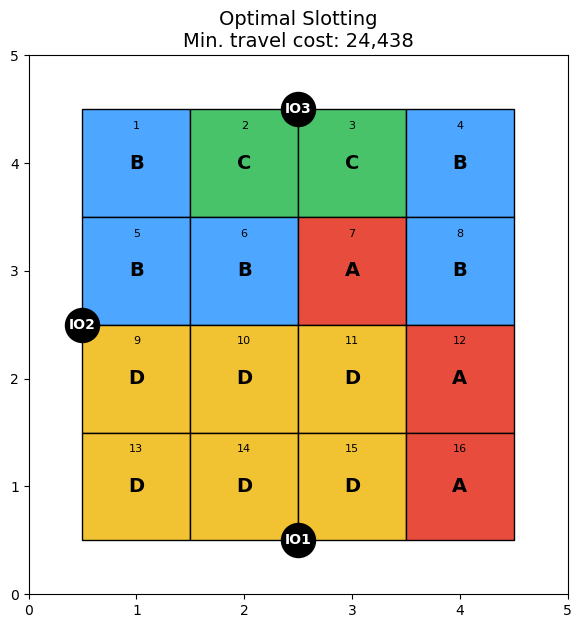

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import pulp

cost_matrix = weights_matrix.astype(float)
slot_list = sorted(storage_locations.keys())


#MILP
# Decision variables: x[i,j] = 1 if item i is assigned to slot j, otherwise 0
x = pulp.LpVariable.dicts("x", (items, slot_list), cat="Binary")

# Defininng the optimization problem (minimization)
prob = pulp.LpProblem("Slotting_MILP_with_weights", pulp.LpMinimize)

# Objective: minimize sum_{i,j} cost_matrix[i,j] * x[i,j]
prob += pulp.lpSum(cost_matrix.loc[i, j] * x[i][j] for i in items for j in slot_list)

# Constraint 1: each slot j assigned to exactly one item
for j in slot_list:
    prob += pulp.lpSum(x[i][j] for i in items) == 1

# Constraint 2: each item i occupies exactly storage_spaces[i] slots
for i in items:
    prob += pulp.lpSum(x[i][j] for j in slot_list) == storage_spaces[i]

# Solve
prob.solve(pulp.PULP_CBC_CMD(msg=0))

# Check Solver status
status = pulp.LpStatus[prob.status]
if status != "Optimal":
    raise RuntimeError(f"Solver did not return optimal status: {status}")

# Get optimal objective value
optimal_cost = pulp.value(prob.objective)

# Get assignment of items to slots
assignment = {}
for j in slot_list:
    assigned = None
    for i in items:
        val = pulp.value(x[i][j])
        if val is not None and val > 0.5:
            assigned = i
            break
    if assigned is None:
        raise RuntimeError(f"No item assigned to slot {j} by solver")
    assignment[j] = assigned

# Results
print("Distance matrix d_kj (IO points x slots):")
print(distance_matrix)
print("\nWeight matrix w_ij (items x slots) — used as cost matrix:")
print(weights_matrix.round(4))

print("\nOptimal total travel cost (sum of w_ij for assigned slots):", optimal_cost)
print("Assigned counts (should equal required storage spaces):", dict(Counter(assignment.values())))
print("Slot -> Item assignment:")
for s in slot_list:
    print(f"{s:2d} : {assignment[s]}")

# Plotting
colors = {"A": "#e74c3c", "B": "#4da6ff", "C": "#49c36a", "D": "#f1c232"}

fig, ax = plt.subplots(figsize=(7, 7))

# Draw storage slots
for s, (x, y) in storage_locations.items():
    item = assignment[s]
    ax.add_patch(plt.Rectangle((x-0.5, y-0.5), 1, 1,
                              facecolor=colors[item],
                               edgecolor="black"))
    ax.text(x, y, item, ha="center", va="center", fontsize=14, weight="bold")
    ax.text(x, y+0.3, str(s), ha="center", va="bottom", fontsize=8)

# Draw IO points
for p, (ix, iy) in io_points.items():
    ax.scatter(ix, iy, s=600, c="black", zorder=6)
    ax.text(ix, iy, f"IO{p}", color="white", ha="center", va="center",
            fontsize=10, fontweight="bold", zorder=7)
    
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_aspect("equal")

# Add title with optimal cost
ax.set_title(f"Optimal Slotting\nMin. travel cost: {int(optimal_cost):,}", fontsize=14)

plt.show()


### 2. Random vs. Dedicated Policies

In addition to the assignment problem and the mathematical model that leads up to an optimal solution, the storage requirements were assessed under dedicated and random storage policies for five high-turnover items across twelve planning periods. The scheduled receipts for each product were complemented with a safety stock equal to 10% of the subsequent period's receipts. This approach ensures that short-term demand variability is covered while respecting all the other assumptions. This is coded in the cell below.

The results show that under dedicated storage policy, the required capacity amounts to 369 spaces, as each item must be allocated enough positions to accommodate its maximum observed requirement. This number is therefore obtained by summing the peak requirements of each item across the twelve periods. Each item must have enough capacity to cover its individual maximum, which leads to a larger total than for the random storage policy. The random storage policy gives that 252 storage spaces are needed. This is determined by identifying the maximum aggregate requirement across all items in any single period. So, available capacity is shared dynamically among items and determined by the peak total load across periods. That also explains the difference between the two storage policies.

In [ ]:
import pandas as pd
import numpy as np

scheduled_receipts = {  "Period 1": {"A": 20, "B": 12,  "C": 66, "D": 22, "E": 97},
                        "Period 2": {"A": 15,  "B": 8, "C": 15, "D": 22, "E": 12},
                        "Period 3": {"A": 30,  "B": 4, "C": 16, "D": 25, "E": 88},
                        "Period 4": {"A": 12, "B": 6,  "C": 17, "D": 21, "E": 66},
                        "Period 5": {"A": 14,  "B": 7, "C": 18, "D": 18, "E": 79},
                        "Period 6": {"A": 60,  "B": 1, "C": 19, "D": 14, "E": 55},
                        "Period 7": {"A": 17, "B": 12,  "C": 15, "D": 23, "E": 9},
                        "Period 8": {"A": 20,  "B": 40, "C": 16, "D": 36, "E": 25},
                        "Period 9": {"A": 21,  "B": 13, "C": 17, "D": 30, "E": 96},
                        "Period 10": {"A": 22, "B": 12, "C": 18, "D": 22, "E": 90},
                        "Period 11": {"A": 23,  "B": 12, "C": 19, "D": 89, "E": 90},
                        "Period 12": {"A": 23,  "B": 12, "C": 15, "D": 22, "E": 88},

}
scheduled_receipts_df = pd.DataFrame(scheduled_receipts).loc[["A", "B", "C", "D", "E"]]

# Safety stock calculation
safety_pct = 0.1 
next_period = scheduled_receipts_df.shift(-1, axis=1, fill_value=0)
safety_stock = np.ceil(safety_pct * next_period).astype(int)

# Calculate required storage spaces S_i
required_storage = scheduled_receipts_df + safety_stock

# Random policy
total_during_each_period = required_storage.values.sum(axis=0)
random_policy = int(np.ceil(total_during_each_period.max()))

# Dedicated policy
max_inventory = required_storage.max(axis=1)
dedicated_policy = int(np.ceil(max_inventory.sum()))

print("=== Scheduled Receipts ===")
print(scheduled_receipts_df, "\n")

print("=== Safety Stock ===")
print(safety_stock, "\n")

print("=== Required per Period (spaces) ===")
print(required_storage.astype(int), "\n")

print("=== Dedicated Storage Calculation ===")
print("Peak by item (spaces):")
print(max_inventory.astype(int))
print(f"\nDedicated storage spaces required: {dedicated_policy}")

print("\n=== Random Storage Calculation ===")
print("Total required spaces by period:")
print(total_during_each_period.astype(int))
print(f"\nRandom storage spaces required: {random_policy}")

=== Scheduled Receipts ===
   Period 1  Period 2  Period 3  Period 4  Period 5  Period 6  Period 7  \
A        20        15        30        12        14        60        17   
B        12         8         4         6         7         1        12   
C        66        15        16        17        18        19        15   
D        22        22        25        21        18        14        23   
E        97        12        88        66        79        55         9   

   Period 8  Period 9  Period 10  Period 11  Period 12  
A        20        21         22         23         23  
B        40        13         12         12         12  
C        16        17         18         19         15  
D        36        30         22         89         22  
E        25        96         90         90         88   

=== Safety Stock ===
   Period 1  Period 2  Period 3  Period 4  Period 5  Period 6  Period 7  \
A         2         3         2         2         6         2         2   
B      